In [1]:
import pandas as pd
import ortega
import numpy as np

!pip install --upgrade ortega
pd.set_option('display.max_rows', None)

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type and the value must contains year, month, day, hour, minute, and second. 

In [2]:
df = pd.read_csv('./data/Annotated_David_Leo.csv', sep=',',header=0)
df = df.dropna(subset=["location-long", "location-lat", "study-local-timestamp"])
df['study-local-timestamp'] = pd.to_datetime(df['study-local-timestamp'])
df.sort_values(['individual-local-identifier', 'study-local-timestamp'], inplace=True)
print('total number of gps points:', df.shape[0])
print('unique id:', df['individual-local-identifier'].unique())

total number of gps points: 69525
unique id: ['David' 'Leo']


/var/folders/ws/4kvjv8pj0xs3vgrbl186twtc0000gn/T/ipykernel_26694/3447935256.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/Annotated_David_Leo.csv', sep=',',header=0)


In [3]:
df.head()

,Unnamed: 0,event-id,timestamp,location-long,location-lat,heading,height-raw,raptor-workshop:migration-state,tag-battery-voltage,sensor-type,...,proj_lat,NDVI,temperature_2m,total_precipitation_sum,u_component_of_wind_10m,v_component_of_wind_10m,elevation,slope,tailwind,crosswind
0,312525,258154952,2013/8/10 1:00,-106.31300,53.00467,0,400,BreedingGrounds,NaN,gps,...,6983861.791,0.452854,288.375277,0.000267,0.109481,0.826680,500,3.177593,0.826680,0.109481
1,312526,258154953,2013/8/25 19:00,-106.31350,53.00467,0,460,BreedingGrounds,NaN,gps,...,6983861.791,0.303695,294.449672,0.000377,-0.240363,-0.435266,501,4.627368,-0.435266,-0.240363
2,312527,258154954,2013/8/25 20:00,-106.31333,53.00467,105,480,BreedingGrounds,NaN,gps,...,6983861.791,0.303695,294.449672,0.000377,-0.240363,-0.435266,501,4.627368,0.344828,0.482645
3,312528,258154955,2013/8/25 21:00,-106.31300,53.00483,0,510,BreedingGrounds,NaN,gps,...,6983891.390,0.303695,294.449672,0.000377,-0.240363,-0.435266,500,3.177593,-0.435266,-0.240363
4,312529,258154956,2013/9/1 20:00,-106.31017,53.00633,0,520,BreedingGrounds,NaN,gps,...,6984168.885,0.230310,292.315321,0.000000,0.582685,2.047949,503,4.875107,2.047949,0.582685


In [4]:
pair = ['Leo', 'David']
pairdf = df[(df["individual-local-identifier"]==pair[0])|(df["individual-local-identifier"]==pair[1])]
print(pairdf.shape[0])

69525


# Convert longitude latitude to epsg:3857
If tracking data are already in projected coordinate system, users can skip this step. Otherwise, longitude and latitude coordinates need to be converted to projected coordinate system coordinates. We recommend using the epsg:3857 projected coordinate system because it is used for rendering maps in many common apps such as Google Maps, OpenStreetMap, etc.

In [7]:
!pip install pyproj fastkml shapely

In [5]:
%%time
import pyproj
from fastkml import kml
from shapely.geometry import Point
from shapely.ops import transform

p = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def convert_to_projected(x, lat, lon):
    point = Point(float(x[lon]), float(x[lat]))
    projected_point = transform(p.transform, point)
    x[lat], x[lon] = projected_point.y, projected_point.x
    return x

pairdf = pairdf.apply(lambda x: convert_to_projected(x, 'location-lat', 'location-long'), axis=1)

CPU times: user 17.1 s, sys: 215 ms, total: 17.3 s
Wall time: 17.4 s


# Topic 1. Concurrent Interaction

## Initializing ORTEGA object
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify the field names based on the data they used.

In the below cell, we use a subset of data between 2013-11-03 and 2013-11-13 to showcase the usage of ORTEGA. Note that in our paper, we used the complete data of David and Leo between 2013-08-09 and 2017-12-31, in total 48,453 GPS points. The complete data can take about 2h to excute interaction analysis.

In [6]:
%%time
concurrent_interaction = ortega.ORTEGA(data=pairdf,
                             start_time='2013-11-03 00:00:00',  ##set a time window to subset data 
                             end_time='2013-11-13 00:00:00',
                             latitude_field = 'proj_lat',
                             longitude_field = 'proj_lon',
                             minute_min_delay=0,
                             minute_max_delay=60,# 1h
                             time_field='study-local-timestamp',
                             id_field='individual-local-identifier',
                             max_el_time_min=60,
                             speed_average=True,
                             attr_fields=['NDVI', 'temperature_2m', 'total_precipitation_sum',
                                          'elevation', 'slope', 'tailwind', 'crosswind']
                             )

2024-02-15 10:45:27.966315 Initializing ORTEGA object...
2024-02-15 10:45:28.024094 Generate PPA list for the two moving entities...
2024-02-15 10:45:28.312746 Generating PPA list completed!
2024-02-15 10:45:28.312931 Initialization success!
CPU times: user 328 ms, sys: 20.4 ms, total: 349 ms
Wall time: 347 ms


In [7]:
print(concurrent_interaction.df1.shape[0],concurrent_interaction.df2.shape[0])

179 55


## Implement interaction analysis

The below cell runs interaction_analysis() and it returns three values. 
- The first value is a list of intersecting PPA pairs as paired built-in Ellipse objects.
- The second return value is a dataframe containing all intersecting PPA pairs. 
- The third return value is a dataframe that includes all identified continuous interaction segments (interaction events).

In [8]:
%%time
concurrent_results = concurrent_interaction.interaction_analysis()

2024-02-15 10:45:32.661519 Complete! 16 pairs of intersecting PPAs found!
2024-02-15 10:45:32.669325 Compute continuous interaction events...
2024-02-15 10:45:32.674241 Complete! 5 continuous interaction events identified!
CPU times: user 230 ms, sys: 5.34 ms, total: 236 ms
Wall time: 236 ms


The below results indicate 10 interaction events between these two moving entities.
The dataframe df_duration includes six columns: 
- No: event no. sorted by start time
- P1: unique id for individual 1
- P2: unique id for individual 2
- Start: start time of the interaction
- End: end time of the interaction
- Duration: duration of the interaction event (in minutes)

In [9]:
%%time
concurrent_results.compute_interaction_duration()
concurrent_results.df_interaction_events

2024-02-15 10:45:34.914429 Computing interaction duration complete!
CPU times: user 3.5 ms, sys: 348 µs, total: 3.85 ms
Wall time: 3.59 ms


,p1,p2,p1_start,p1_end,p2_start,p2_end,difference,duration
0,David,Leo,2013-11-03 08:00:00,2013-11-03 10:00:00,2013-11-03 08:00:00,2013-11-03 09:00:00,0.0,120.0
1,David,Leo,2013-11-07 07:00:00,2013-11-07 09:00:00,2013-11-07 08:00:00,2013-11-07 09:00:00,60.0,120.0
2,David,Leo,2013-11-08 08:00:00,2013-11-08 11:00:00,2013-11-08 09:00:00,2013-11-08 12:00:00,60.0,240.0
3,David,Leo,2013-11-10 09:00:00,2013-11-10 11:00:00,2013-11-10 10:00:00,2013-11-10 11:00:00,60.0,120.0
4,David,Leo,2013-11-12 07:00:00,2013-11-12 12:00:00,2013-11-12 07:00:00,2013-11-12 11:00:00,0.0,300.0


## Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

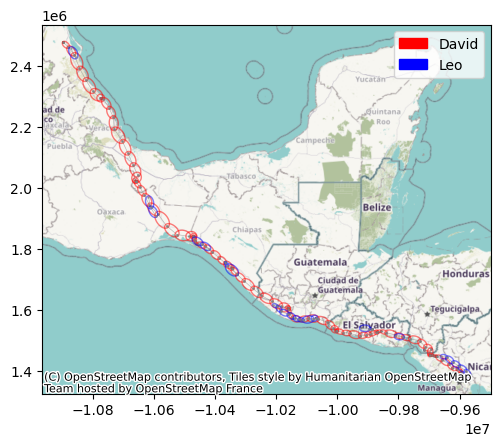

CPU times: user 1.14 s, sys: 108 ms, total: 1.25 s
Wall time: 1.02 s


In [11]:
%%time
#show two trajectories only
ortega.visualization.plot_original_tracks(concurrent_interaction, colors=['red', 'blue'])

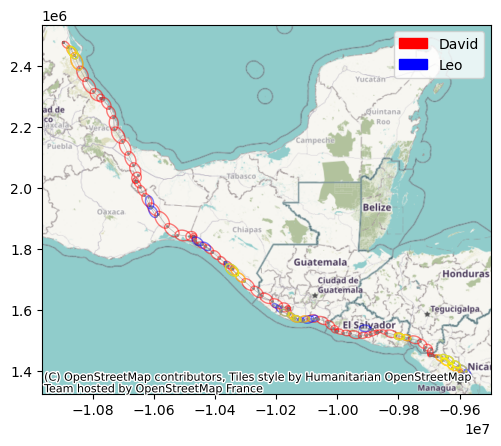

In [12]:
#show two trajectories with the intersecting PPAs highlighted
ortega.visualization.plot_interaction(concurrent_interaction, concurrent_results.intersection_ellipse_pair, 
                                      colors=['red', 'blue', 'yellow'])

## Add contextual variables

In [13]:
#method=mean
concurrent_results.attach_attributes(col=['NDVI', 'temperature_2m', 'total_precipitation_sum', 'elevation', 'slope', 'tailwind', 'crosswind'], method='mean')

#method=difference
concurrent_results.attach_attributes(col=['NDVI', 'temperature_2m', 'total_precipitation_sum', 'elevation', 'slope', 'tailwind', 'crosswind'], method='difference')

In [15]:
concurrent_results.df_all_intersection_pairs.head()

,p1,p1_t_start,p1_t_end,p1_startlat,p1_startlon,p1_endlat,p1_endlon,p1_speed,p1_direction,p1_start_attrs,...,p1_attrs_crosswind,p2_attrs_crosswind,attrs_mean_crosswind,attrs_diff_NDVI,attrs_diff_temperature_2m,attrs_diff_total_precipitation_sum,attrs_diff_elevation,attrs_diff_slope,attrs_diff_tailwind,attrs_diff_crosswind
0,David,2013-11-03 08:00:00,2013-11-03 09:00:00,2459955.882,-10879977.41,2435912.356,-10861609.70,8.404621,142.622496,"{'NDVI': 0.675740251, 'temperature_2m': 294.32...",...,-0.022702,-0.077872,-0.050287,-0.057172,-0.253092,-0.000002,-7.0,-0.171873,-0.214121,0.055170
1,David,2013-11-03 09:00:00,2013-11-03 10:00:00,2435912.356,-10861609.70,2391818.968,-10843835.31,13.205860,158.045250,"{'NDVI': 0.461046164, 'temperature_2m': 294.75...",...,-0.009878,-0.077872,-0.043875,-0.147282,0.125529,-0.000004,-6.5,-0.171873,-0.136193,0.067994
2,David,2013-11-07 07:00:00,2013-11-07 08:00:00,1736073.159,-10343974.06,1716548.380,-10328630.90,6.897785,141.838669,"{'NDVI': 0.763461046, 'temperature_2m': 299.61...",...,0.060581,0.444573,0.252577,0.128168,-0.246216,0.000311,6.5,1.782009,-0.244258,-0.383992
3,David,2013-11-07 08:00:00,2013-11-07 09:00:00,1716548.380,-10328630.90,1696231.175,-10306422.66,8.361041,132.453830,"{'NDVI': 0.789231163, 'temperature_2m': 299.32...",...,0.355327,0.444573,0.399950,0.094633,-0.740438,0.001380,-2.5,0.463269,0.034742,-0.089246
4,David,2013-11-08 08:00:00,2013-11-08 09:00:00,1589345.413,-10155287.53,1573891.872,-10148051.76,4.739904,154.909723,"{'NDVI': 0.490741531, 'temperature_2m': 298.46...",...,-0.033386,0.601523,0.284068,-0.148136,0.186768,0.003313,-2.5,-0.407487,-0.844705,-0.634909


## Compute PPA size and speed and use violin plots to show the distribution

In [25]:
ppasize_list = concurrent_interaction.compute_ppa_area() 

Descriptive statistics of PPA perimeter (square kilometer) for id David:
count     160.000000
mean      305.803841
std       440.801746
min         0.000233
25%         0.006725
50%        34.208000
75%       486.372420
max      1825.954914
dtype: float64
Descriptive statistics of PPA perimeter (square kilometer) for id Leo:
count      35.000000
mean      328.082440
std       325.873758
min         0.000233
25%         0.069200
50%       285.055565
75%       505.532832
max      1188.855828
dtype: float64


In [26]:
ppaspeed_list = concurrent_interaction.compute_ppa_speed()

Descriptive statistics of PPA speed (m/s) for id David:
count    160.000000
mean       3.275631
std        4.133011
min        0.004947
25%        0.010051
50%        0.455420
75%        6.583466
max       13.837411
dtype: float64
Descriptive statistics of PPA speed (m/s) for id Leo:
count    35.000000
mean      4.399998
std       3.705442
min       0.004947
25%       0.073403
50%       4.452234
75%       7.279973
max      11.165403
dtype: float64


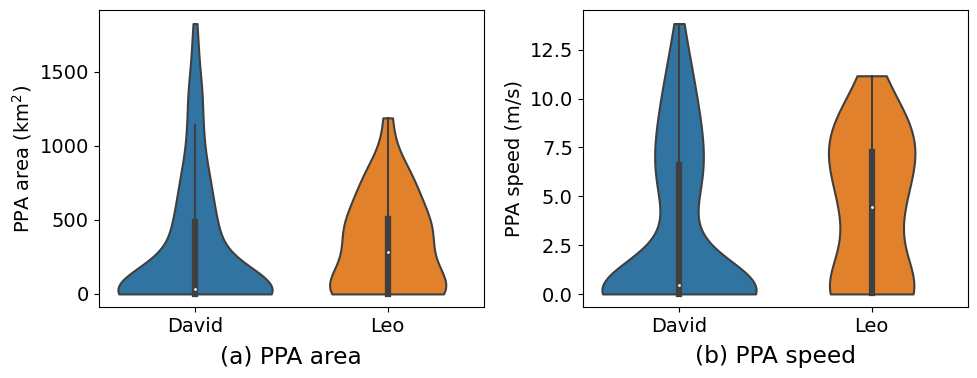

In [27]:
import seaborn
import matplotlib.pyplot as plt

# Prepare the data for the first violin plot
df1 = pd.concat([pd.DataFrame({'PPA': ppasize_list[0], 'ID': str(concurrent_interaction.id1)}), 
                 pd.DataFrame({'PPA': ppasize_list[1], 'ID': str(concurrent_interaction.id2)})])

# Prepare the data for the second violin plot
df2 = pd.concat([pd.DataFrame({'PPA': ppaspeed_list[0], 'ID': str(concurrent_interaction.id1)}), 
                 pd.DataFrame({'PPA': ppaspeed_list[1], 'ID': str(concurrent_interaction.id2)})])

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# First plot
seaborn.violinplot(x='ID', y='PPA', data=df1, ax=axs[0],cut=0)
axs[0].set_xlabel('')
axs[0].set_ylabel('PPA area (km$^2$)') #'PPA perimeter (km)
# axs[0].set_ylim([0, 170])
axs[0].annotate('(a) PPA area', xy=(0.5, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
             size='large', ha='center', va='baseline')

# Second plot
seaborn.violinplot(x='ID', y='PPA', data=df2, ax=axs[1],cut=0)
axs[1].set_xlabel('')
axs[1].set_ylabel('PPA speed (m/s)')
# axs[1].set_ylim([0, 15])
axs[1].annotate('(b) PPA speed', xy=(0.5, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
             size='large', ha='center', va='baseline')

plt.tight_layout()
# plt.savefig("Concurrent_vulture_"+str(concurrent_interaction.id1)+"_"+str(concurrent_interaction.id2)+"_ppa_size_speed.png", dpi=300)
plt.show()


Remove non-active (non-movement) points and do the same plot

In [28]:
ppasize_list = concurrent_interaction.compute_ppa_area(lim=[100000000, 100000000]) 
#with lim parameter, the user can exclude small values (stationary activities) from the results
#the first value of parameter 'lim' is for moving entity 1 and the second is for the moving entity 2
ppaspeed_list = concurrent_interaction.compute_ppa_speed(lim=[5,5])

Descriptive statistics of PPA perimeter (square kilometer) for id David:
count      72.000000
mean      671.706479
std       433.635522
min       109.752780
25%       338.079145
50%       527.689086
75%       903.103224
max      1825.954914
dtype: float64
Descriptive statistics of PPA perimeter (square kilometer) for id Leo:
count      22.000000
mean      519.661853
std       261.353243
min       137.767157
25%       327.025439
50%       468.925001
75%       704.293231
max      1188.855828
dtype: float64
Descriptive statistics of PPA speed (m/s) for id David:
count    53.000000
mean      8.619639
std       2.332612
min       5.059633
25%       6.640415
50%       8.404621
75%      10.437230
max      13.837411
dtype: float64
Descriptive statistics of PPA speed (m/s) for id Leo:
count    17.000000
mean      7.767562
std       1.566422
min       5.353080
25%       6.892632
50%       7.395568
75%       8.757427
max      11.165403
dtype: float64


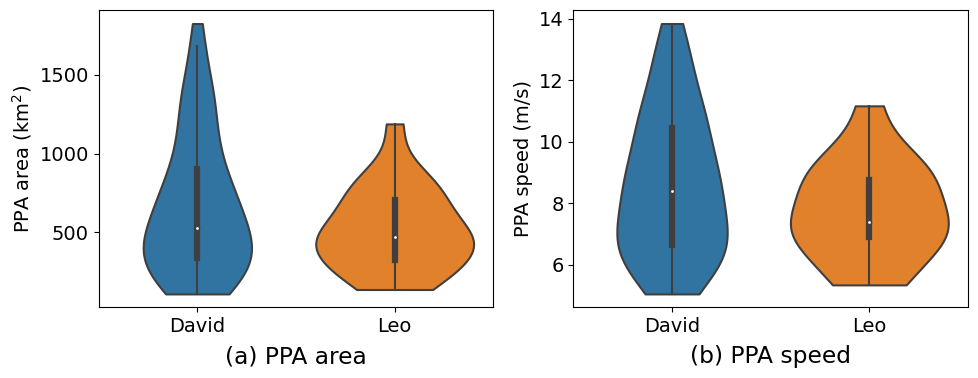

In [31]:
# Prepare the data for the first violin plot
df1 = pd.concat([pd.DataFrame({'PPA': ppasize_list[0], 'ID': str(concurrent_interaction.id1)}), 
                 pd.DataFrame({'PPA': ppasize_list[1], 'ID': str(concurrent_interaction.id2)})])

# Prepare the data for the second violin plot
df2 = pd.concat([pd.DataFrame({'PPA': ppaspeed_list[0], 'ID': str(concurrent_interaction.id1)}), 
                 pd.DataFrame({'PPA': ppaspeed_list[1], 'ID': str(concurrent_interaction.id2)})])

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# First plot
seaborn.violinplot(x='ID', y='PPA', data=df1, ax=axs[0],cut=0)
axs[0].set_xlabel('')
axs[0].set_ylabel('PPA area (km$^2$)')
# axs[0].set_ylim([0, 170])
axs[0].annotate('(a) PPA area', xy=(0.5, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
             size='large', ha='center', va='baseline')

# Second plot
seaborn.violinplot(x='ID', y='PPA', data=df2, ax=axs[1],cut=0)
axs[1].set_xlabel('')
axs[1].set_ylabel('PPA speed (m/s)')
# axs[1].set_ylim([0, 15])
axs[1].annotate('(b) PPA speed', xy=(0.5, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
             size='large', ha='center', va='baseline')

plt.tight_layout()
# plt.savefig("Concurrent_vulture_"+str(concurrent_interaction.id1)+"_"+str(concurrent_interaction.id2)+"_ppa_size_speed.png", dpi=300)
plt.show()

# Topic 2. Delayed interaction: 1 day - 1 week

In [23]:
delayed_interaction = ortega.ORTEGA(data=pairdf,
#                              start_time='2017-10-01 00:00:00',  ##set a time window to subset data
#                              end_time='2017-10-31 00:00:00',
                             latitude_field = 'proj_lat',
                             longitude_field = 'proj_lon',
                             minute_min_delay=1441, 
                             minute_max_delay=10080, #1 week
                             time_field='study-local-timestamp',
                             id_field='individual-local-identifier',
                             max_el_time_min=60,
                             speed_average=True,
                             attr_fields=['NDVI', 'temperature_2m', 'total_precipitation_sum',
                                          'elevation', 'slope', 'tailwind', 'crosswind']
                             )

delayed_results = delayed_interaction.interaction_analysis()

2023-08-24 00:27:59.060711 Initializing ORTEGA object...
2023-08-24 00:27:59.084005 Generate PPA list for the two moving entities...
2023-08-24 00:28:35.769170 Generating PPA list completed!
2023-08-24 00:28:35.775205 Initialization success!
2023-08-24 01:29:20.893093 Complete! 375 pairs of intersecting PPAs found!
2023-08-24 01:29:20.899063 Compute continuous interaction events...
2023-08-24 01:29:20.930492 Complete! 70 continuous interaction events identified!


In [24]:
delayed_results.df_interaction_events

,p1,p2,p1_start,p1_end,p2_start,p2_end,difference
0,David,Leo,2013-11-02 07:00:00,2013-11-02 08:00:00,2013-10-30 09:00:00,2013-10-30 10:00:00,-4200.0
1,David,Leo,2013-11-02 08:00:00,2013-11-02 09:00:00,2013-10-30 14:00:00,2013-10-30 16:00:00,-3960.0
2,David,Leo,2013-11-02 08:00:00,2013-11-02 09:00:00,2013-10-30 20:00:00,2013-10-30 22:00:00,-3600.0
3,David,Leo,2014-10-16 13:00:00,2014-10-16 17:00:00,2014-10-14 07:00:00,2014-10-14 10:00:00,-3240.0
4,David,Leo,2014-10-17 08:00:00,2014-10-17 10:00:00,2014-10-14 09:00:00,2014-10-14 10:00:00,-4260.0
5,David,Leo,2014-10-19 10:00:00,2014-10-19 12:00:00,2014-10-15 14:00:00,2014-10-15 18:00:00,-5520.0
6,David,Leo,2014-10-19 11:00:00,2014-10-19 12:00:00,2014-10-16 08:00:00,2014-10-16 09:00:00,-4500.0
7,David,Leo,2014-10-19 12:00:00,2014-10-19 13:00:00,2014-10-15 15:00:00,2014-10-15 16:00:00,-5580.0
8,David,Leo,2014-10-19 12:00:00,2014-10-19 16:00:00,2014-10-16 08:00:00,2014-10-16 12:00:00,-4560.0
9,David,Leo,2014-10-20 09:00:00,2014-10-20 11:00:00,2014-10-16 14:00:00,2014-10-16 17:00:00,-5460.0


# Topic 3. Explore the difference in speed and movement  direction when individuals interact

In [24]:
def get_stats_label(title, data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    stats_str = f"{title}\nMean: {mean_val:.2f}, Std: {std_val:.2f}, \nMin: {min_val:.2f}, Max: {max_val:.2f}"
    return [stats_str]

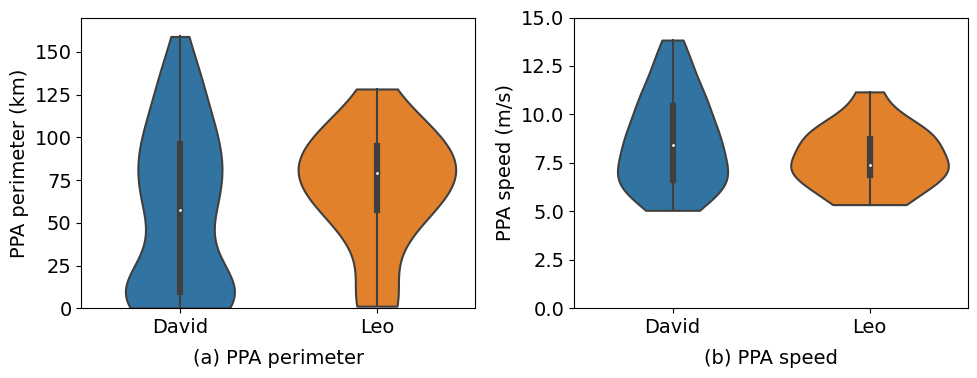

In [49]:
# Prepare the data for the first violin plot
df1 = pd.concat([pd.DataFrame({'PPA': [x/1000 for x in ppasize_list[0]], 'ID': str(concurrent_interaction.id1)}), 
                 pd.DataFrame({'PPA': [x/1000 for x in ppasize_list[1]], 'ID': str(concurrent_interaction.id2)})])

# Prepare the data for the second violin plot
df2 = pd.concat([pd.DataFrame({'PPA': ppaspeed_list[0], 'ID': str(concurrent_interaction.id1)}), 
                 pd.DataFrame({'PPA': ppaspeed_list[1], 'ID': str(concurrent_interaction.id2)})])

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# First plot
seaborn.violinplot(x='ID', y='PPA', data=df1, ax=axs[0],cut=0)
axs[0].set_xlabel('')
axs[0].set_ylabel('PPA perimeter (km)')
axs[0].set_ylim([0, 170])
axs[0].annotate('(a) PPA perimeter', xy=(0.5, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
              ha='center', va='baseline')

# Second plot
seaborn.violinplot(x='ID', y='PPA', data=df2, ax=axs[1],cut=0)
axs[1].set_xlabel('')
axs[1].set_ylabel('PPA speed (m/s)')
axs[1].set_ylim([0, 15])
axs[1].annotate('(b) PPA speed', xy=(0.5, 0), xytext=(0, -40),
             xycoords='axes fraction', textcoords='offset points',
              ha='center', va='baseline')

plt.tight_layout()